In [6]:
from __future__ import division, print_function
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
def random_split(spectra, test_size=0.3, random_state=None, shuffle=True, stratify=None):
    """implement random_split by using sklearn.model_selection.train_test_split function. See
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    for more infomation.
    """
    return train_test_split(
        spectra,
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle,
        stratify=stratify)


def kennardstone(spectra, test_size=0.2, metric='euclidean', *args, **kwargs):
    """Kennard Stone Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    --------
    Kennard, R. W., & Stone, L. A. (1969). Computer aided design of experiments.
    Technometrics, 11(1), 137-148. (https://www.jstor.org/stable/1266770)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        distance = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def spxy(spectra, yvalues, test_size=0.2, metric='euclidean', *args, **kwargs):
    """SPXY Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    ---------
    Galvao et al. (2005). A method for calibration and validation subset partitioning.
    Talanta, 67(4), 736-740. (https://www.sciencedirect.com/science/article/pii/S003991400500192X)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        yvalues = yvalues.reshape(yvalues.shape[0], -1)
        distance_spectra = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        distance_y = cdist(yvalues, yvalues, metric=metric, *args, **kwargs)
        distance_spectra = distance_spectra / distance_spectra.max()
        distance_y = distance_y / distance_y.max()

        distance = distance_spectra + distance_y
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def max_min_distance_split(distance, train_size):
    """sample set split method based on maximun minimun distance, which is the core of Kennard Stone
    method
    Parameters
    ----------
    distance : distance matrix
        semi-positive real symmetric matrix of a certain distance metric
    train_size : train data sample size
        should be greater than 2
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero-based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero-based
    """

    select_pts = []
    remaining_pts = [x for x in range(distance.shape[0])]

    # first select 2 farthest points
    first_2pts = np.unravel_index(np.argmax(distance), distance.shape)
    select_pts.append(first_2pts[0])
    select_pts.append(first_2pts[1])

    # remove the first 2 points from the remaining list
    remaining_pts.remove(first_2pts[0])
    remaining_pts.remove(first_2pts[1])

    for i in range(train_size - 2):
        # find the maximum minimum distance
        select_distance = distance[select_pts, :]
        min_distance = select_distance[:, remaining_pts]
        min_distance = np.min(min_distance, axis=0)
        max_min_distance = np.max(min_distance)

        # select the first point (in case that several distances are the same, choose the first one)
        points = np.argwhere(select_distance == max_min_distance)[:, 1].tolist()
        for point in points:
            if point in select_pts:
                pass
            else:
                select_pts.append(point)
                remaining_pts.remove(point)
                break
    return select_pts, remaining_pts

In [7]:
import sys
import os
import math
import re
import json
import scipy
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import IPython.display

from sklearn.metrics import *  # we use global() to access the imported functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier # ExtraTreeClassifier only works in ensembles
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
# from scipy.integrate import quad
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import OneHotEncoder
from statsmodels.multivariate import manova
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

from pyNNRW.elm import ELMClassifier
from pyNNRW.rvfl import RVFLClassifier

from qsi.vis.plt2base64 import plt2html
from qsi.vis.plot_components import plot_components_2d
from qsi.vis.feature_importance import plot_feature_importance
from qsi.vis.unsupervised_dimension_reductions import unsupervised_dimension_reductions
from cla.vis.confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score, classification_report

X.shape (50, 1322)  y.shape (50,)
No module named 'rpy2'


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


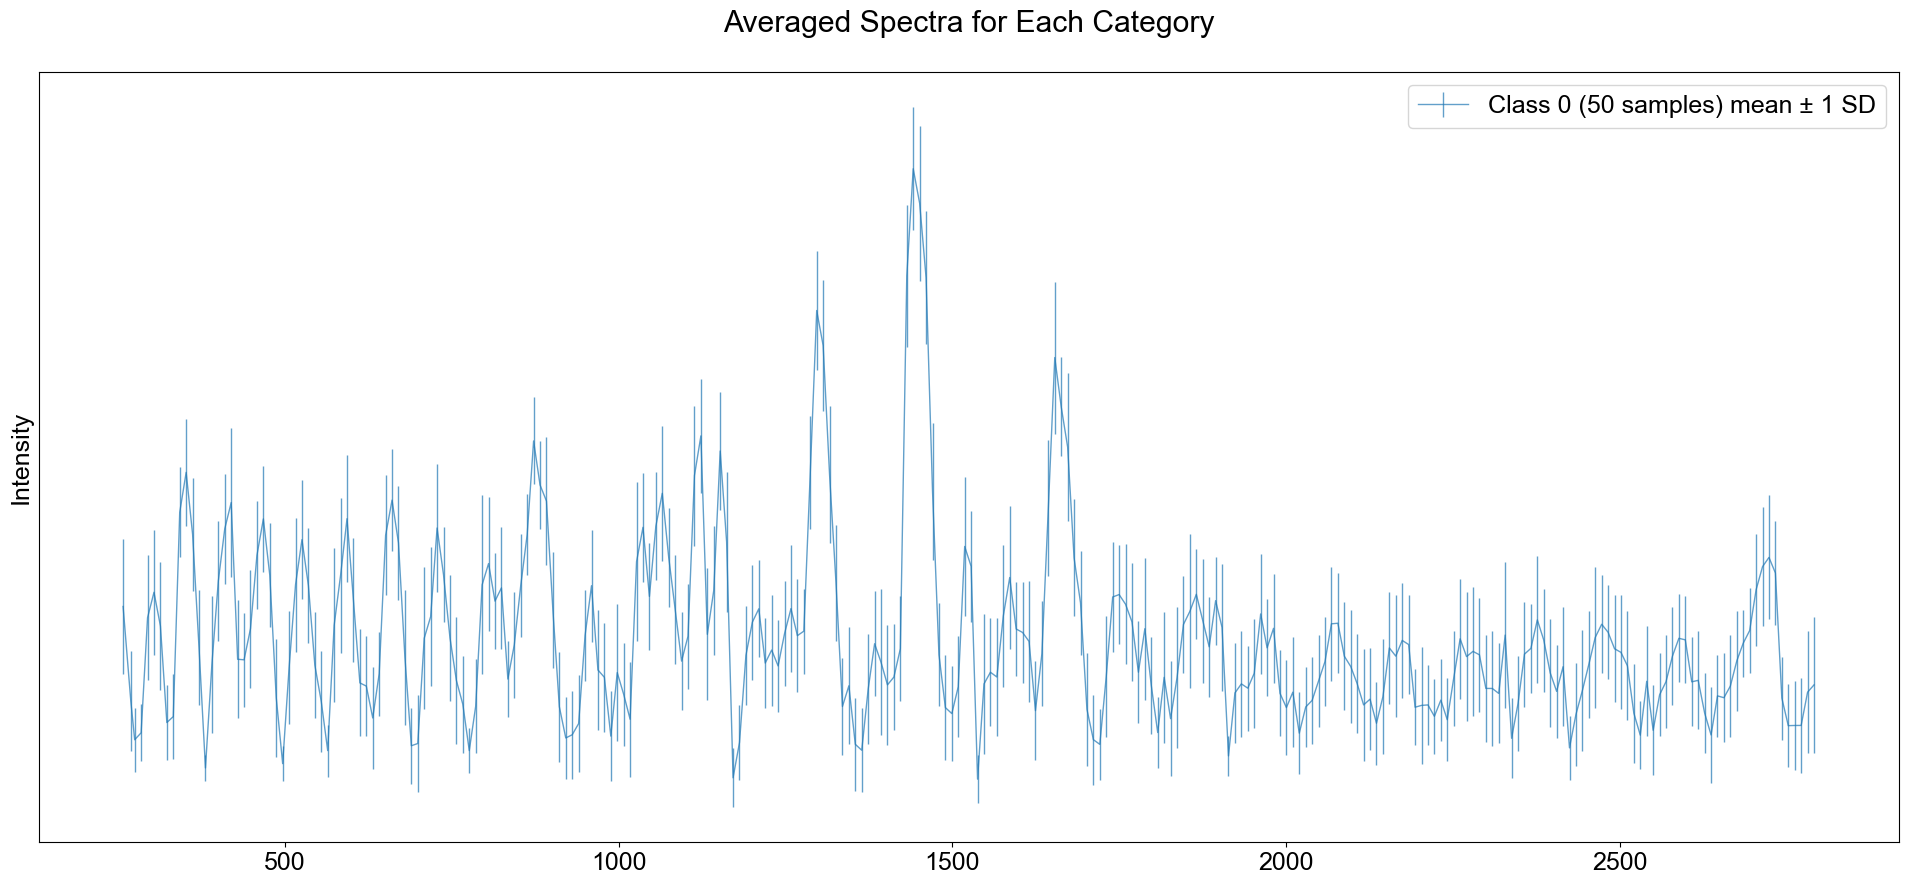

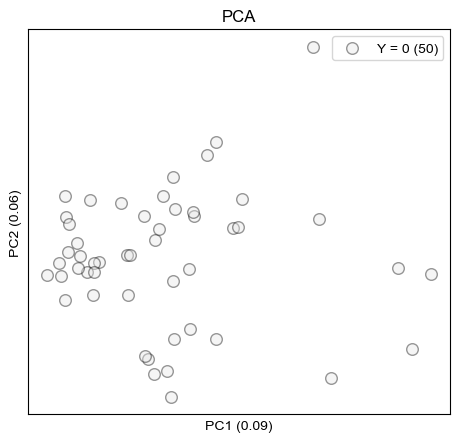

In [8]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm0_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [9]:
X.shape

(50, 264)

In [10]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [11]:
import numpy as np

# 保存训练集数据
np.savetxt('gm0.train_data.csv', X_train, delimiter=',')
np.savetxt('gm0.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm0.val_data.csv', X_val, delimiter=',')
np.savetxt('gm0.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm0.test_data.csv', X_test, delimiter=',')
np.savetxt('gm0.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


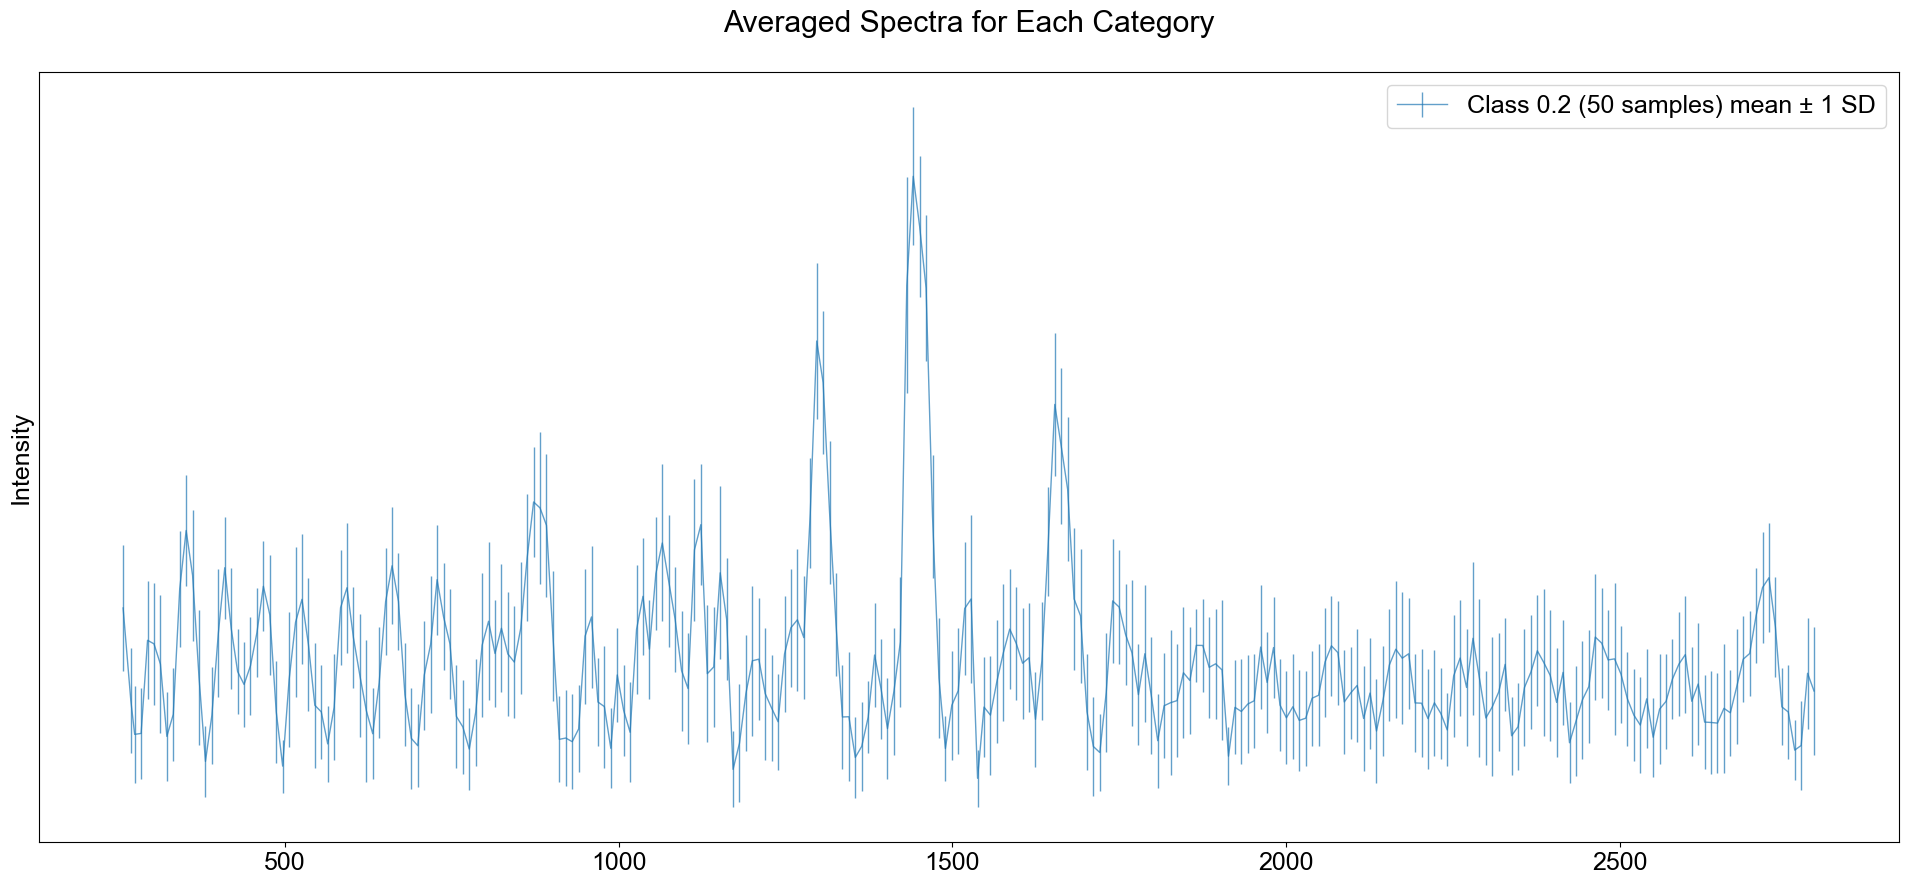

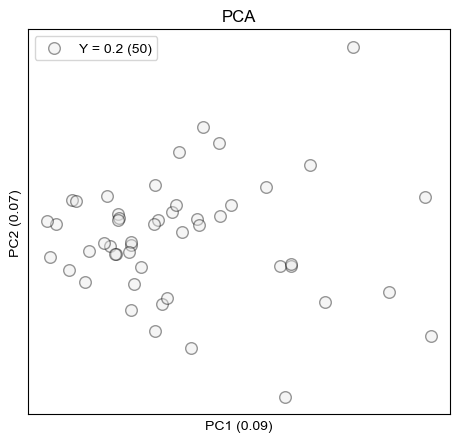

In [12]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm20_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [13]:
X.shape

(50, 264)

In [14]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [15]:
import numpy as np

# 保存训练集数据
np.savetxt('gm20.train_data.csv', X_train, delimiter=',')
np.savetxt('gm20.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm20.val_data.csv', X_val, delimiter=',')
np.savetxt('gm20.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm20.test_data.csv', X_test, delimiter=',')
np.savetxt('gm20.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


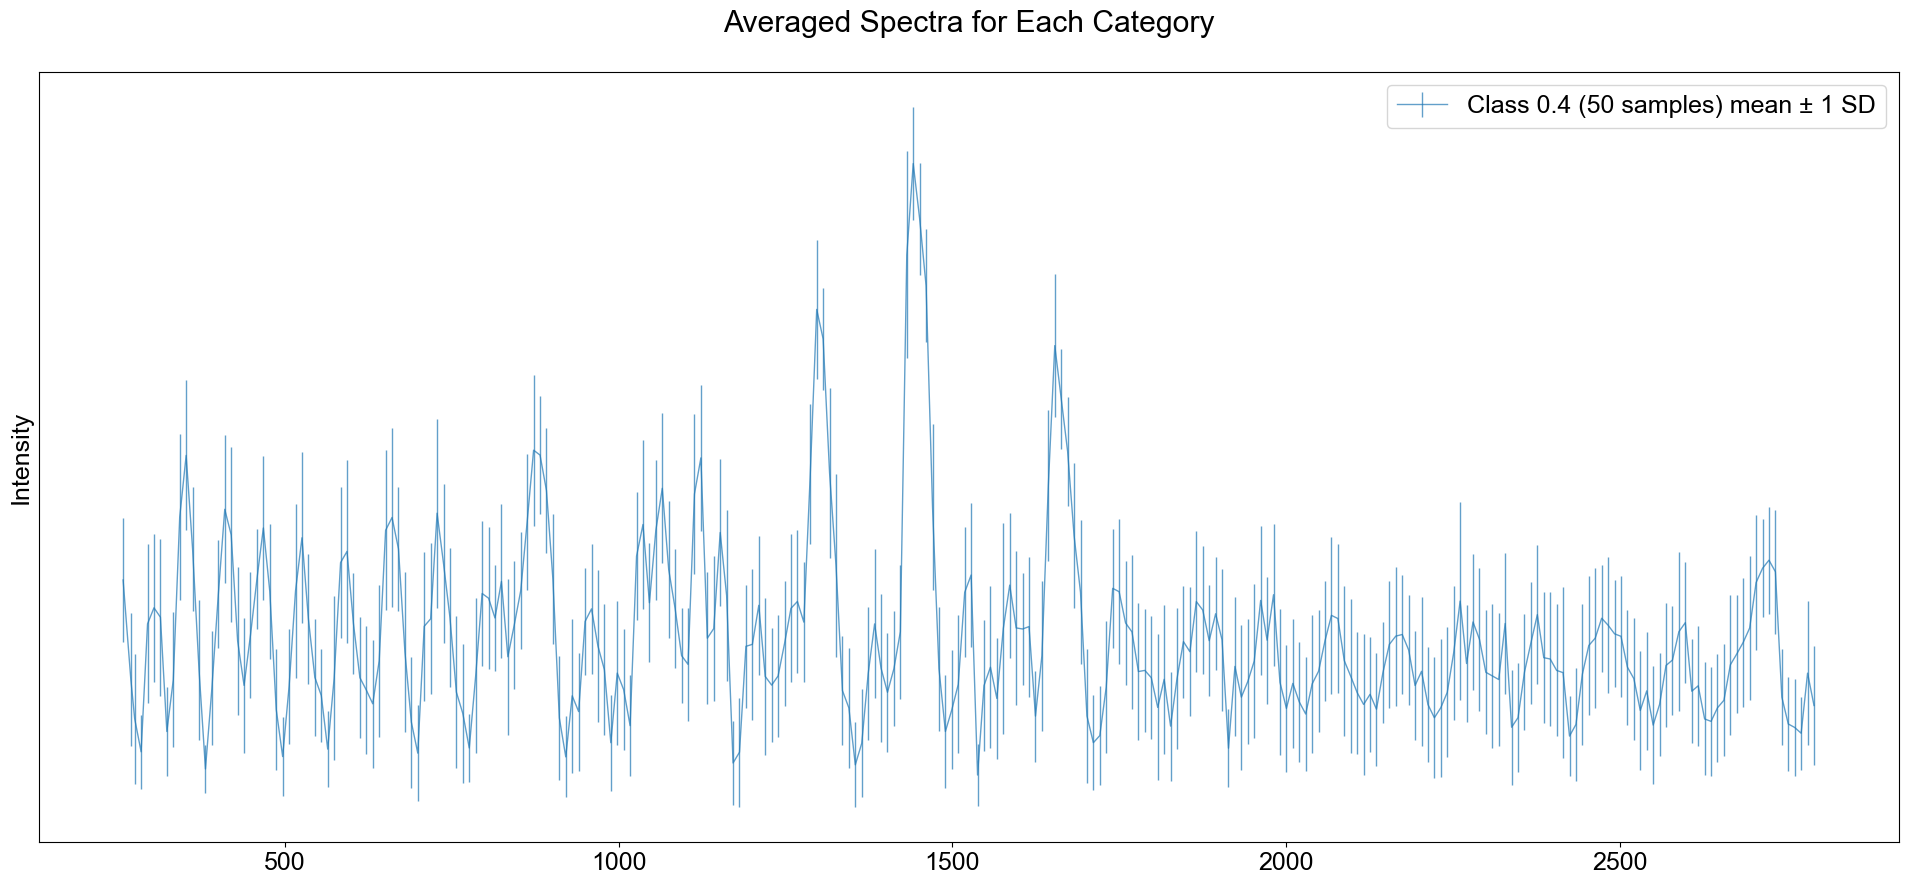

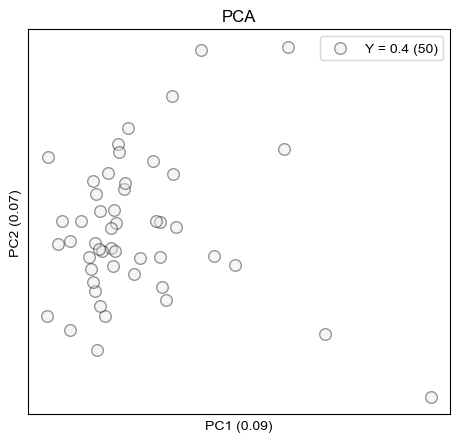

In [16]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm40_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [17]:
X.shape

(50, 264)

In [18]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [19]:
import numpy as np

# 保存训练集数据
np.savetxt('gm40.train_data.csv', X_train, delimiter=',')
np.savetxt('gm40.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm40.val_data.csv', X_val, delimiter=',')
np.savetxt('gm40.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm40.test_data.csv', X_test, delimiter=',')
np.savetxt('gm40.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


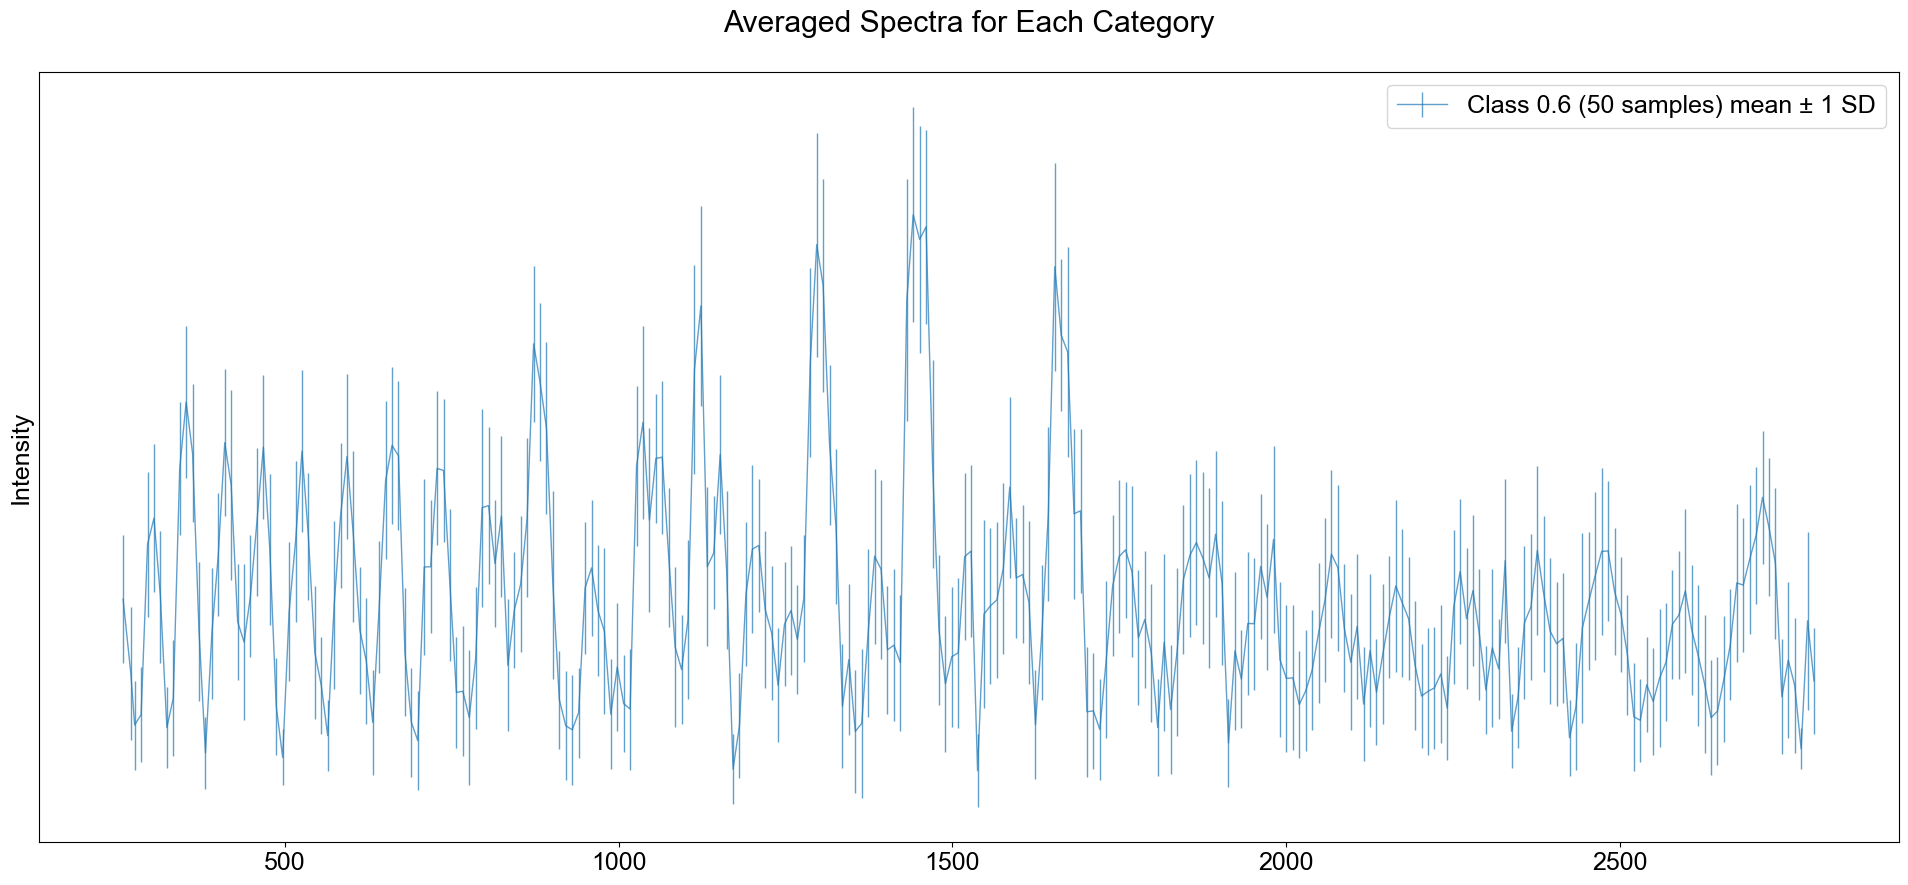

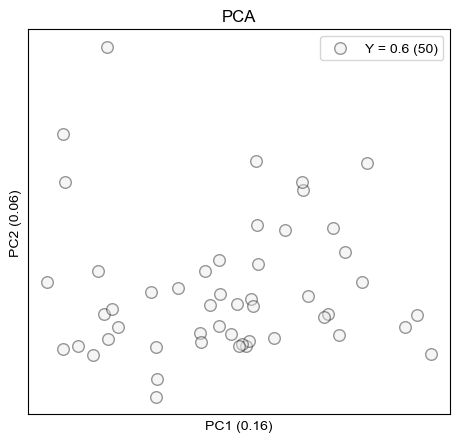

In [20]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm60_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [21]:
X.shape

(50, 264)

In [22]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [23]:
import numpy as np

# 保存训练集数据
np.savetxt('gm60.train_data.csv', X_train, delimiter=',')
np.savetxt('gm60.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm60.val_data.csv', X_val, delimiter=',')
np.savetxt('gm60.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm60.test_data.csv', X_test, delimiter=',')
np.savetxt('gm60.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


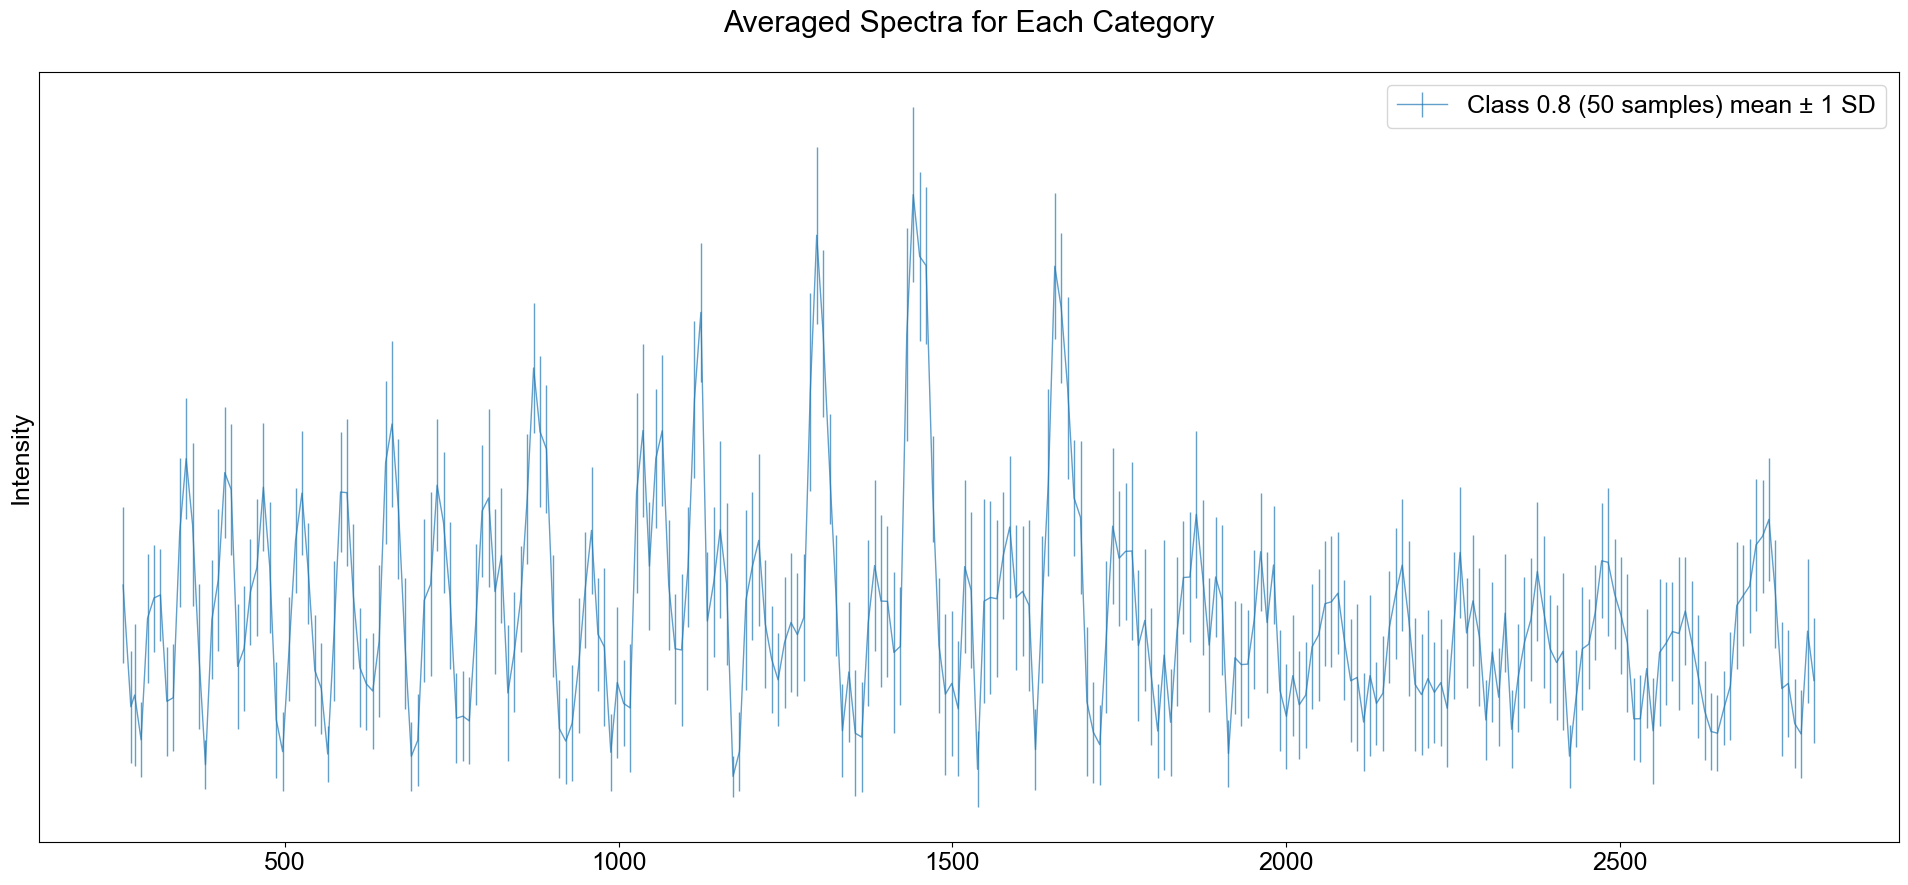

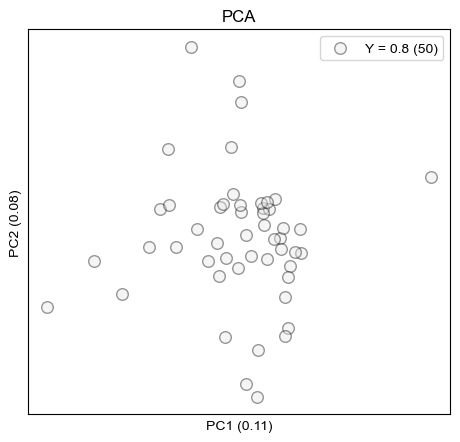

In [24]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm80_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [25]:
X.shape

(50, 264)

In [26]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [27]:
import numpy as np

# 保存训练集数据
np.savetxt('gm80.train_data.csv', X_train, delimiter=',')
np.savetxt('gm80.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm80.val_data.csv', X_val, delimiter=',')
np.savetxt('gm80.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm80.test_data.csv', X_test, delimiter=',')
np.savetxt('gm80.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


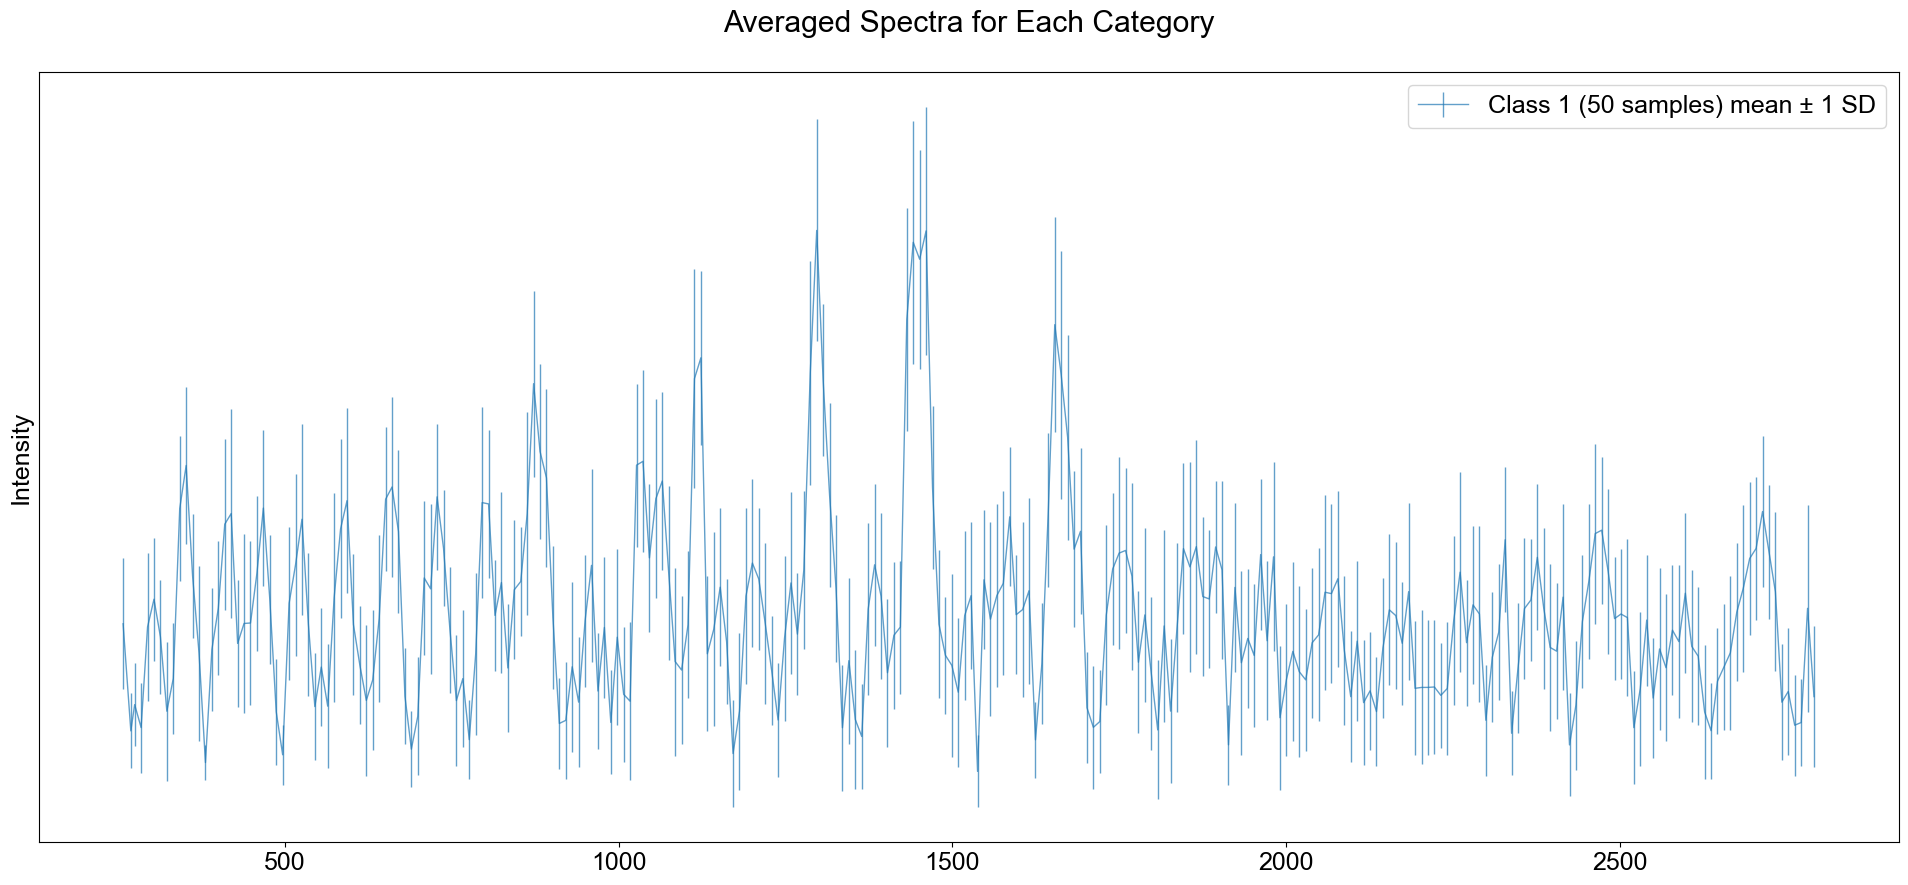

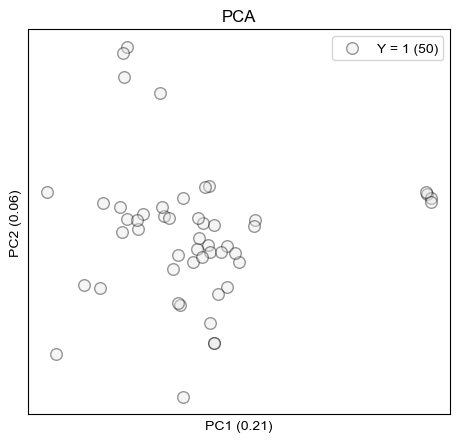

In [28]:
from qsi import io

X, y, X_names, labels = io.open_dataset('gm100_merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline

X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])
io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [29]:
X.shape

(50, 264)

In [30]:
from qsi.io.pre import kennardstone_split
import numpy as np

# 第一次划分，得到校准集和测试集
train_index, test_index = kennardstone_split(X, test_size=0.2)
X_cal = X[train_index]
X_test = X[test_index]
y_cal = y[train_index]
y_test = y[test_index]

# 第二次划分，从校准集中得到训练集和验证集
train_index, val_index = kennardstone_split(X_cal, test_size=0.1)
X_train = X_cal[train_index]
X_val = X_cal[val_index]
y_train = y_cal[train_index]
y_val = y_cal[val_index]

In [31]:
import numpy as np

# 保存训练集数据
np.savetxt('gm100.train_data.csv', X_train, delimiter=',')
np.savetxt('gm100.train_labels.csv', y_train, delimiter=',')

# 保存验证集数据
np.savetxt('gm100.val_data.csv', X_val, delimiter=',')
np.savetxt('gm100.val_labels.csv', y_val, delimiter=',')

# 保存测试集数据
np.savetxt('gm100.test_data.csv', X_test, delimiter=',')
np.savetxt('gm100.test_labels.csv', y_test, delimiter=',')

In [32]:
train_files = ['gm0.train_data.csv', 'gm20.train_data.csv', 'gm40.train_data.csv', 'gm60.train_data.csv', 'gm80.train_data.csv', 'gm100.train_data.csv']
val_files = ['gm0.val_data.csv', 'gm20.val_data.csv', 'gm40.val_data.csv', 'gm60.val_data.csv', 'gm80.val_data.csv', 'gm100.val_data.csv']
test_files = ['gm0.test_data.csv', 'gm20.test_data.csv', 'gm40.test_data.csv', 'gm60.test_data.csv', 'gm80.test_data.csv', 'gm100.test_data.csv']
train_label_files = ['gm0.train_labels.csv', 'gm20.train_labels.csv', 'gm40.train_labels.csv', 'gm60.train_labels.csv', 'gm80.train_labels.csv', 'gm100.train_labels.csv']
val_label_files = ['gm0.val_labels.csv', 'gm20.val_labels.csv', 'gm40.val_labels.csv', 'gm60.val_labels.csv', 'gm80.val_labels.csv', 'gm100.val_labels.csv']
test_label_files = ['gm0.test_labels.csv', 'gm20.test_labels.csv', 'gm40.test_labels.csv', 'gm60.test_labels.csv', 'gm80.test_labels.csv', 'gm100.test_labels.csv']

In [33]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for train_file, val_file, test_file, train_label_file, val_label_file, test_label_file in zip(train_files, val_files, test_files, train_label_files, val_label_files, test_label_files):
    train_data = np.loadtxt(train_file, delimiter=',')
    val_data = np.loadtxt(val_file, delimiter=',')
    test_data = np.loadtxt(test_file, delimiter=',')
    train_labels = np.loadtxt(train_label_file, delimiter=',')
    val_labels = np.loadtxt(val_label_file, delimiter=',')
    test_labels = np.loadtxt(test_label_file, delimiter=',')

    X_train.append(train_data)
    X_val.append(val_data)
    X_test.append(test_data)
    y_train.append(train_labels)
    y_val.append(val_labels)
    y_test.append(test_labels)

X_train = np.concatenate(X_train, axis=0)
X_val = np.concatenate(X_val, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [34]:
print(X_train)
print(y_train)
print(X_val)
print(y_val)
print(X_test)
print(y_test)

[[239.74047592 144.78872646 -11.44543348 ...  -5.92488812 140.99587665
   -3.5477512 ]
 [224.14845831 203.50381283   2.47158689 ... -10.63517899  74.36717131
  128.73772388]
 [176.21550136  39.45649952  -7.77097482 ... 217.43853157  87.33716634
   48.02897214]
 ...
 [112.94348195  -3.01471099  28.92809258 ...  -1.05208933  25.78163649
   74.75578652]
 [ 89.20384528  -2.61677883   1.9755318  ...  49.11072405 117.374297
   18.07475439]
 [ 47.22909493  -1.60118091  13.28367416 ...   8.11366774 219.14591175
    6.3168589 ]]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0

In [35]:
np.savetxt('merged_train_data.csv', X_train, delimiter=',')
np.savetxt('merged_val_data.csv', X_val, delimiter=',')
np.savetxt('merged_test_data.csv', X_test, delimiter=',')
np.savetxt('merged_train_labels.csv', y_train, delimiter=',')
np.savetxt('merged_val_labels.csv', y_val, delimiter=',')
np.savetxt('merged_test_labels.csv', y_test, delimiter=',')

In [36]:
import matplotlib.pyplot as plt
# 指定其他字体，例如SimHei（黑体）
plt.rcParams['font.family'] = 'Arial'

load dataset from gm_merged_data.CSV
X.shape (300, 1322)  y.shape (300,)


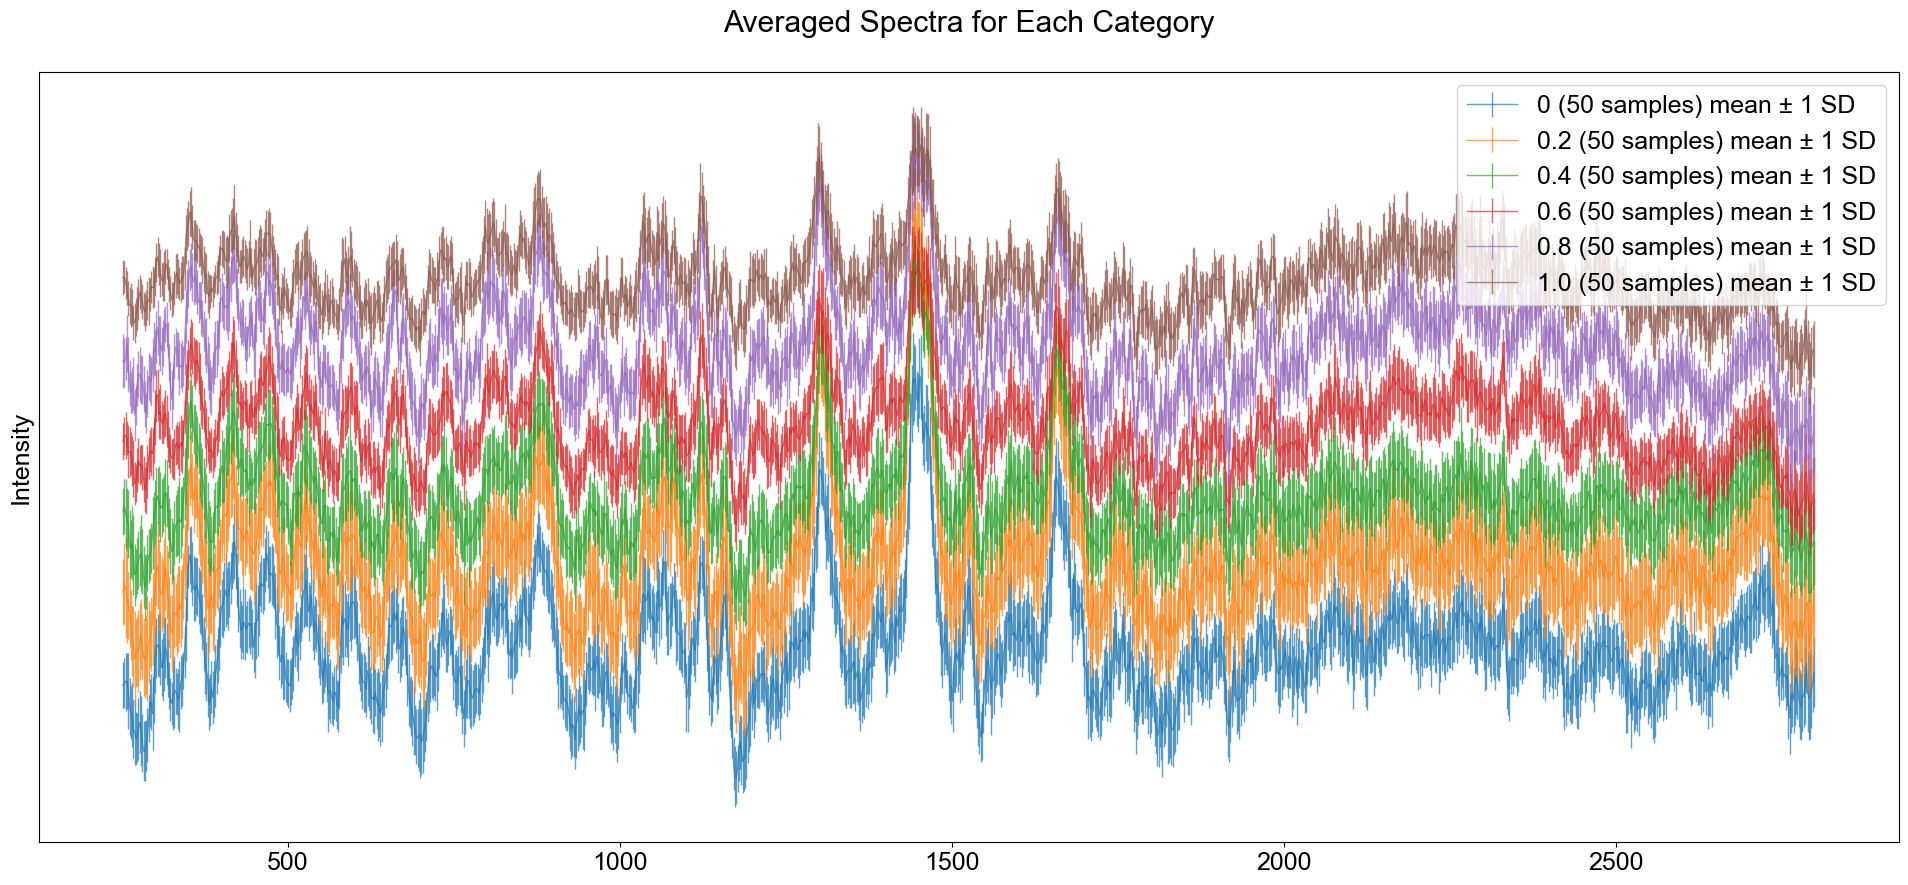

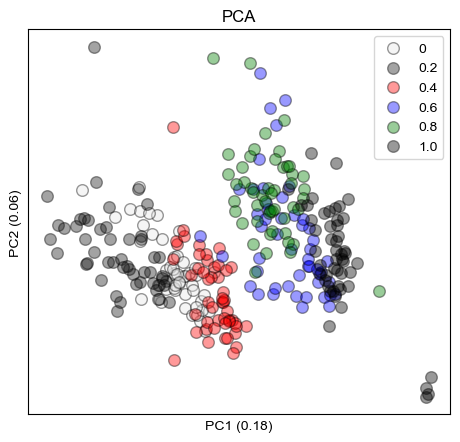

窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


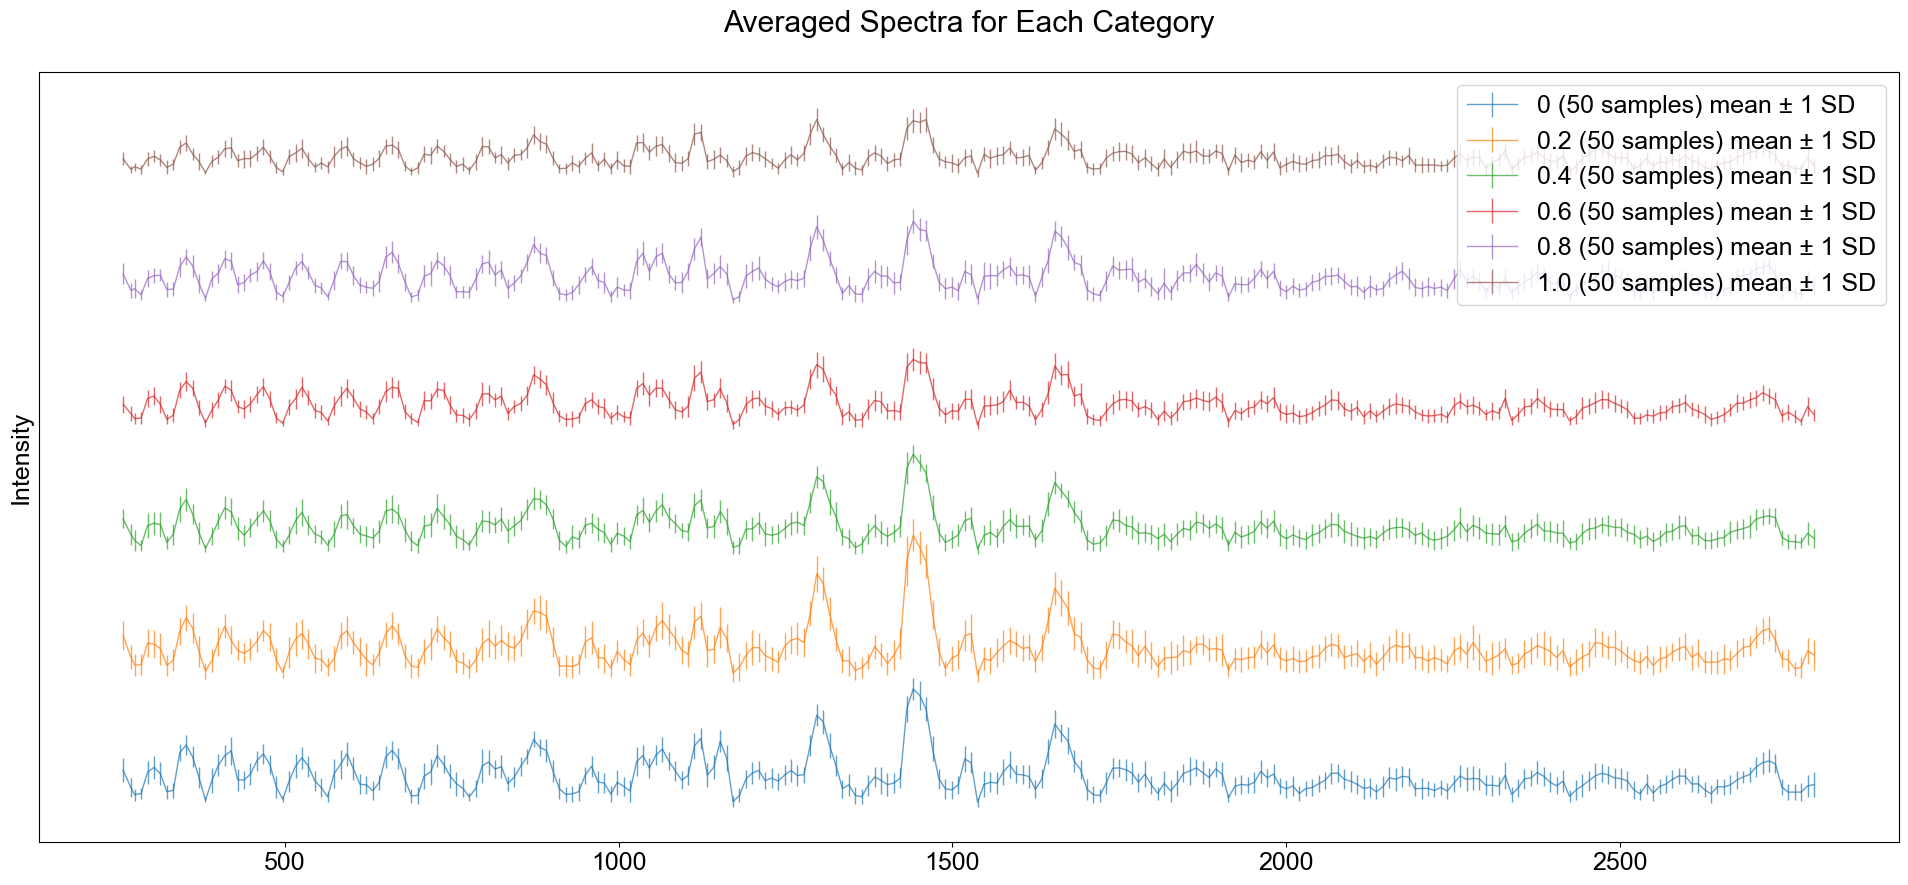

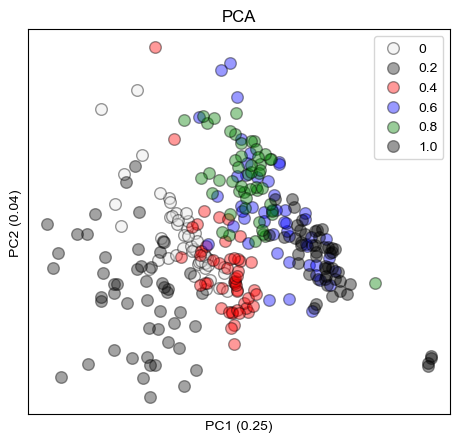

In [37]:
from qsi import io
X, yc, X_names, _, labels = io.load_dataset('gm_adulteration', x_range = list(range(104,1426)), shift=200)

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])
io.draw_class_average(X, yc, X_names, labels=labels, SD=1, shift=800)
_ = io.scatter_plot(X, yc, labels=labels)

In [38]:
import numpy as np
min_raman_shift = np.min(X_names)  
max_raman_shift = np.max(X_names)  
print(f"Raman Shift: min = {min_raman_shift}, max = {max_raman_shift}") 

Raman Shift: min = 257.0712, max = 2791.076


In [39]:
labels

['0', '0.2', '0.4', '0.6', '0.8', '1.0']

In [40]:
import numpy as np
y = np.asfarray(np.array(labels)[yc]) # convert class label to continuous value

In [41]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体大小和粗细
rcParams.update({
    'font.size': 15,        # 全局字体大小
    'font.weight': 'bold',  # 全局字体粗细
    'axes.titlesize': 16,   # 图标题字体大小
    'axes.titleweight': 'bold',  # 图标题字体粗细
    'axes.labelsize': 14,   # 坐标轴标签字体大小
    'axes.labelweight': 'bold',  # 坐标轴标签字体粗细
    'xtick.labelsize': 13,  # x轴刻度标签字体大小
    'ytick.labelsize': 13,  # y轴刻度标签字体大小
    'legend.fontsize': 12,  # 图例字体大小
    'axes.linewidth': 2.0,  # 坐标轴边框线条宽度
    'xtick.major.width': 2.0,  # x轴刻度线宽度
    'xtick.minor.width': 2.0,  # x轴次刻度线宽度
    'ytick.major.width': 2.0,  # y轴刻度线宽度
    'ytick.minor.width': 2.0,  # y轴次刻度线宽度
})

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
from tqdm import tqdm
from IPython.core.display import display, HTML
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

def draw_regression_plots(X_train, y_train, 
                          X_test, y_test, title,show_data_ticks=True, show_grid=True):
    '''
    X_train : 训练集真实值
    y_train : 训练集预测值
    X_test : 测试集真实值
    y_test : 测试集预测值
    title : 图表标题
    '''
    
    # 将数据转换为numpy数组
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    # 计算性能指标
    r2_train = r2_score(X_train, y_train)
    r2_test = r2_score(X_test, y_test)
    rmse_train = np.sqrt(mean_squared_error(X_train, y_train))
    rmse_test = np.sqrt(mean_squared_error(X_test, y_test))
    
    # 创建一个包含三个子图的画布
    plt.figure(figsize=(7, 6))
    
    # # 1. 按索引排列的真实值与预测值散点图
    # plt.subplot(1, 3, 1)
    # # plt.title(title + '\n' + 
    # #           f'rc2 = {r2_train:.3f}, rp2 = {r2_test:.3f}, ' +
    # #           f'RMSEC = {rmse_train:.3f}, RMSEP = {rmse_test:.3f}')
    
    # # # 绘制训练集数据（倒三角，红色）
    # # plt.scatter(range(len(X_train)), X_train, marker='v', 
    # #             label='Train Ground Truth', color='red', alpha=0.5)
    # # plt.scatter(range(len(X_train)), y_train, marker='v', 
    # #             label='Train Prediction', color='red', alpha=0.3)
    
    # # 绘制测试集数据（星号，蓝色）
    # test_indices = range(len(X_train), len(X_train) + len(X_test))
    # plt.scatter(test_indices, X_test, marker='*', 
    #             label='Test Ground Truth', color='blue', alpha=0.5)
    # plt.scatter(test_indices, y_test, marker='*', 
    #             label='Test Prediction', color='blue', alpha=0.3)
    # # 在右下角添加性能指标文本
    # plt.text(0.53, 0.02, 
    #          f'$R^2$_training set = {r2_train:.3f}\nRMSE_training set = {rmse_train:.3f}\n$R^2$_test set = {r2_test:.3f}\nRMSE_test set = {rmse_test:.3f}',
    #          transform=plt.gca().transAxes, 
    #          horizontalalignment='left',
    #          verticalalignment='bottom',
    #          fontsize=12,
    #          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    # plt.legend()
    # plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)
    # plt.tick_params(axis='x', which='major', bottom=True, top=False) 
    # plt.tick_params(axis='y', which='major', left=True, right=False)
    # ax = plt.gca()
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2.0)

    # # 2. 预测值 vs 真实值的对角散点图
    # plt.subplot(1, 3, 2)
    
    # 绘制训练集数据
    plt.scatter(X_train, y_train, marker='v', 
                color='red', alpha=0.5, label='Training set')
    
    # 绘制测试集数据
    plt.scatter(X_test, y_test, marker='*', 
                color='blue', alpha=0.5, label='Test set')
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(-0.16, 1.16)
    plt.ylim(-0.16, 1.16)
    plt.xlabel('Actual value', fontsize=16)
    plt.ylabel('Predicted value', fontsize=16)
    
    
    # 绘制y=x参考线
    min_val = min(min(X_train), min(X_test), min(y_train), min(y_test))
    max_val = max(max(X_train), max(X_test), max(y_train), max(y_test))
    plt.title(title, fontsize=16)
    plt.plot([-0.16, 1.16], [-0.16, 1.16], 'k--', linewidth=1)


    # 在右下角添加性能指标文本
    plt.text(0.6, 0.05, 
             f'$R^2$_training set = {r2_train:.3f}\nRMSE_training set = {rmse_train:.3f}\n$R^2$_test set = {r2_test:.3f}\nRMSE_test set = {rmse_test:.3f}',
             transform=plt.gca().transAxes, 
             horizontalalignment='left',
             verticalalignment='bottom',
             fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    plt.legend(loc='upper left')
    plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)
    plt.tick_params(axis='x', which='major', bottom=True, top=False) 
    plt.tick_params(axis='y', which='major', left=True, right=False)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)

    # # 3. 残差图（预测值与真实值的差值）
    # plt.subplot(1, 3, 3)
    
    # # 计算残差
    # residuals_train = y_train.flatten() - X_train.flatten()
    # residuals_test = y_test.flatten() - X_test.flatten()
    
    
    # # 绘制测试集残差
    # plt.scatter(X_test.flatten(), residuals_test, marker='*', 
    #             color='blue', alpha=0.5, label='Test Residuals')
    
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)
    # plt.xlabel('True Values', fontsize=16)
    # plt.axhline(y=0, color='r', linestyle='-')
    # plt.title('Residuals')
    # plt.legend()
    # plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)
    # plt.tick_params(axis='x', which='major', bottom=True, top=False) 
    # plt.tick_params(axis='y', which='major', left=True, right=False)
    # ax = plt.gca()
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2.0)

    plt.tight_layout()
    plt.show()


In [46]:
def run_regressors(X_train, X_val, X_test, y_train, y_val, y_test, 
                   clfs = ['linear regression', 'ridge', 'LASSO', 
                           'SVR(linear)', 'SVR(rbf)', 'SVR(poly)', 
                           'PLSR',
                           'Random Forest Regressor', # 'ANN', 
                           'K-Neighbors Regressor',
                           'Gaussian Weighted K-Neighbors Regressor'],
                           X_names = None,
                           order = False,
                           verbose=2):
    '''
    Run a series of regression models
    
    Parameters:
    -----------    
    verbose: 
        verbose = 0 or False, no intermediate output
        verbose = 1, output the last summary table
        verbose = 2, also output plots
        verbose = 3, output everything
    '''

    dic_metrics = {}
    
    for idx, clf_name in enumerate(clfs):

        if verbose > 1:
            display(HTML('<h2>' + str(idx+1) + '. ' + str(clf_name) + '</h2>'))
        if clf_name == 'linear regression':

            from sklearn.linear_model import LinearRegression

            lr = LinearRegression()
            yp = lr.fit(X_train, y_train).predict(X_test)
            y_pred_train = lr.predict(X_train)  
            best_hparam = 'N/A'

        elif clf_name == 'PLSR':
            # Partial Least Squares Regression
            from sklearn.cross_decomposition import PLSRegression

            hparams = list(range(1, X_train.shape[1])) # Number of components to keep. Should be in [1, n_features]
            val_scores = []
            for nc in hparams:
                plsr = PLSRegression(n_components=nc).fit(X_train, y_train)
                val_scores.append(plsr.score(X_val, y_val))

            if verbose > 1:
                ax = plt.figure().gca()
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                #plt.title('val score ~ components')
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                plt.xlabel('Components',fontsize=16)
                plt.ylabel('Val score',fontsize=16)
                # plt.xscale('log')
                plt.plot(hparams, val_scores)
                plt.scatter(hparams, val_scores, label='components')
                plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
                plt.tick_params(axis='x', which='major', bottom=True, top=False) 
                plt.tick_params(axis='y', which='major', left=True, right=False)
                # 设置边框加粗
                ax = plt.gca()  # 获取当前图形对象
                for spine in ax.spines.values():
                    spine.set_linewidth(2.0)  # 边框线条加粗
                        
            best_hparam = hparams[np.argmax(val_scores)]
            plsr = PLSRegression(n_components = best_hparam).fit(X_train, y_train)

            # print('test score:', ridge.score(X_test, y_test))
            yp = plsr.predict(X_test)
            y_pred_train = plsr.predict(X_train)
            print('Training set R2: ', r2_score(y_train, y_pred_train))
            print('Test set R2:', r2_score(y_test, yp))
        
        else:
            print('Undefined regression model: ' + clf_name)

        dic_metrics[clf_name] = best_hparam, round(r2_score(y_test, yp), 3), round(mean_squared_error(y_test, yp),3) # save R2 and MSE to dict
        
        if verbose > 1:
            draw_regression_plots(y_train, y_pred_train, y_test, yp, title = clf_name)

    if verbose > 0:
        display(HTML('<h2>Summary</h2>'))
        tbl_html = '<table><tr><th>Regressor</th><th>best hparam</th><th>R2</th><th>MSE</th></tr>'
        for k,v in dic_metrics.items():
            tbl_html += '<tr><td>'+str(k)+'</td><td>'+str(v[0])+'</td><td>'+str(v[1])+'</td><td>'+str(v[2])+'</td></tr>'
        display(HTML( tbl_html + '</table>'))

    return dic_metrics

In [47]:
X_train.shape, y_train.shape

((216, 264), (216,))

In [48]:
feature_indices = [123,122,124,108,86,85,107,125,89]

In [49]:
X_train = X_train[:, feature_indices] # 训练集选择的特征
X_train.shape

(216, 9)

In [50]:
X_train.shape

(216, 9)

In [51]:
X_val = X_val[:, feature_indices]
X_val.shape

(24, 9)

In [52]:
X_test = X_test[:, feature_indices]
X_test.shape

(60, 9)

In [53]:
X_names = [1440.754, 1431.112, 1450.396, 1296.119, 1083.988, 1074.345, 1286.477, 1460.039, 1112.915]

Training set R2:  0.6263137106854229
Test set R2: 0.6797521883919777


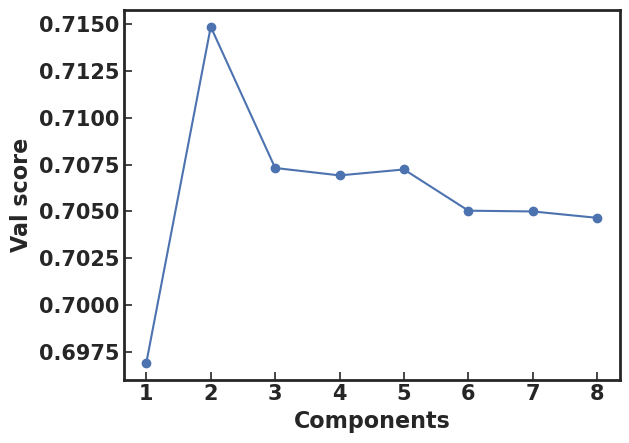

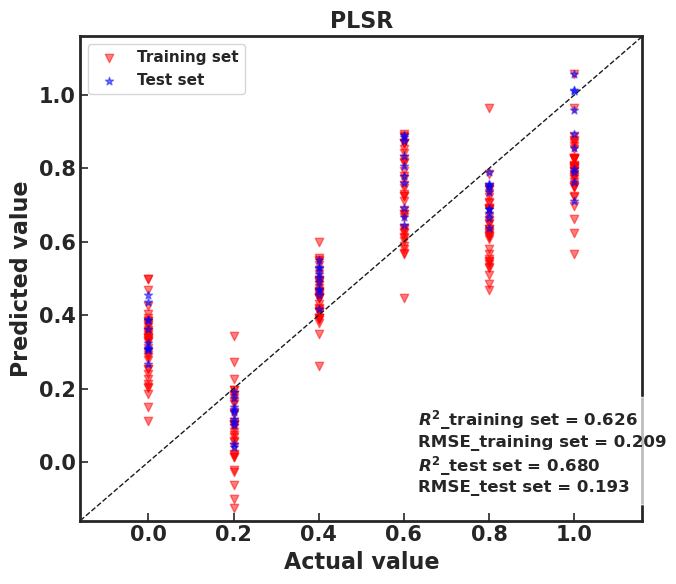

Regressor,best hparam,R2,MSE
PLSR,2,0.68,0.037


{'PLSR': (2, 0.68, 0.037)}

In [54]:
run_regressors(X_train, X_val, X_test, y_train, y_val, y_test, clfs = ['PLSR'])

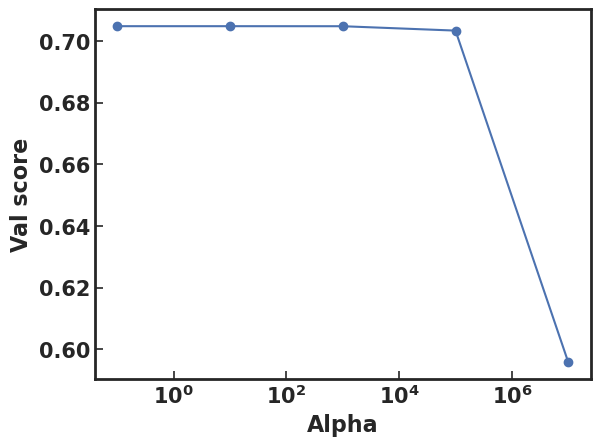

Training set R2:  0.6342922088809526
Test set R2: 0.7011471884436347
Best param 0.1


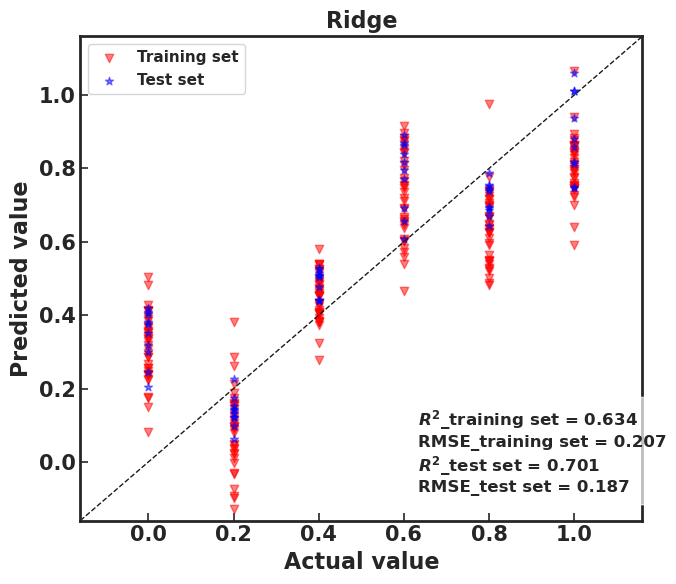

In [56]:
# Ridge
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

hparams = [.1, 10, 1000, 100000, 10000000]
val_scores = []
for alpha in hparams:
    ridge = Ridge(alpha = alpha).fit(X_train, y_train)
    val_scores.append(ridge.score(X_val, y_val))

# plt.title('val score ~ alpha')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Alpha',fontsize=16)
plt.ylabel('Val score',fontsize=16)
plt.xscale('log')
plt.plot(hparams, val_scores, marker='o')
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
plt.tick_params(axis='x', which='major', bottom=True, top=False) 
plt.tick_params(axis='y', which='major', left=True, right=False)
# 设置边框加粗
ax = plt.gca()  # 获取当前图形对象
for spine in ax.spines.values():
    spine.set_linewidth(2.0)  # 边框线条加粗
plt.show()

best_hparam = hparams[np.argmax(val_scores)]
ridge = Ridge(alpha = best_hparam).fit(X_train, y_train)

# print('test score:', ridge.score(X_test, y_test))
yp = ridge.predict(X_test)
ytp = ridge.predict(X_train)
y_pred_train = ridge.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))
print('Best param', best_hparam)
draw_regression_plots(y_train, ytp, y_test, yp, title = 'Ridge')

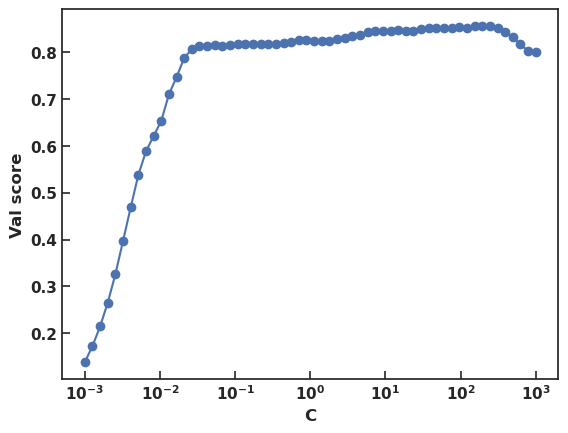

194.14919457438816

In [58]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt


Cs = np.logspace(-3, 3, 60)
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'rbf', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

# plt.title('val score ~ C')
plt.xlabel('C')
plt.ylabel('Val score')
plt.xscale('log')
plt.plot(Cs, val_scores, marker='o')
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
plt.tick_params(axis='x', which='major', bottom=True, top=False) 
plt.tick_params(axis='y', which='major', left=True, right=False)  
plt.show()

best_C = Cs[np.argmax(val_scores)]
best_C

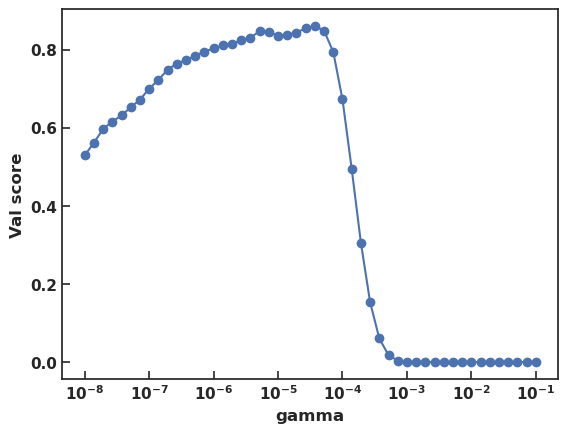

3.727593720314938e-05

In [59]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt


gs = np.logspace(-8, -1, 50)
val_scores = []
for gamma in gs:
    svr = SVR(kernel = 'rbf', gamma=gamma).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

# plt.title('val score ~ C')
plt.xlabel('gamma')
plt.ylabel('Val score')
plt.xscale('log')
plt.plot(gs, val_scores, marker='o')
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
plt.tick_params(axis='x', which='major', bottom=True, top=False) 
plt.tick_params(axis='y', which='major', left=True, right=False)  
plt.show()

best_gamma = gs[np.argmax(val_scores)]
best_gamma

Training set R2:  0.929991061349812
Test set R2: 0.862241945217839
Best C 194.14919457438816
Best gamma 3.727593720314938e-05


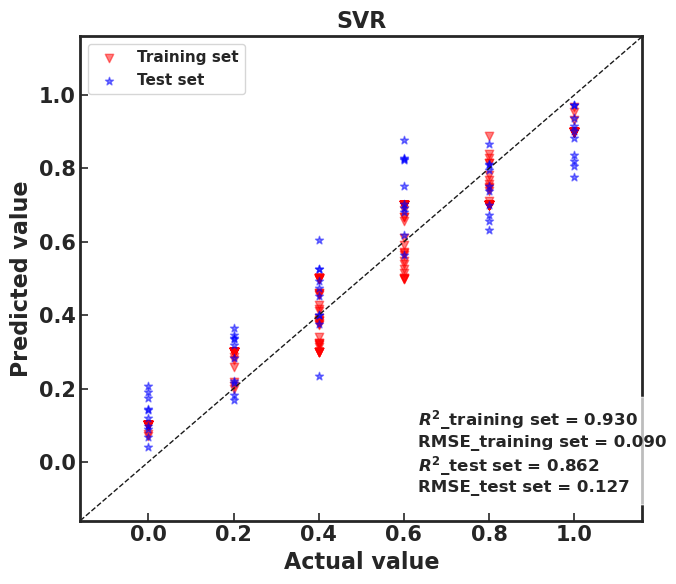

In [60]:
svr = SVR(kernel = 'rbf', C=best_C, gamma=best_gamma)
yp = svr.fit(X_train, y_train).predict(X_test)
ytp = svr.fit(X_train, y_train).predict(X_train)
y_pred_train = svr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))
print('Test set R2:', r2_score(y_test, yp))
print('Best C', best_C)
print('Best gamma', best_gamma)
draw_regression_plots(y_train, ytp, y_test, yp, title = 'SVR')

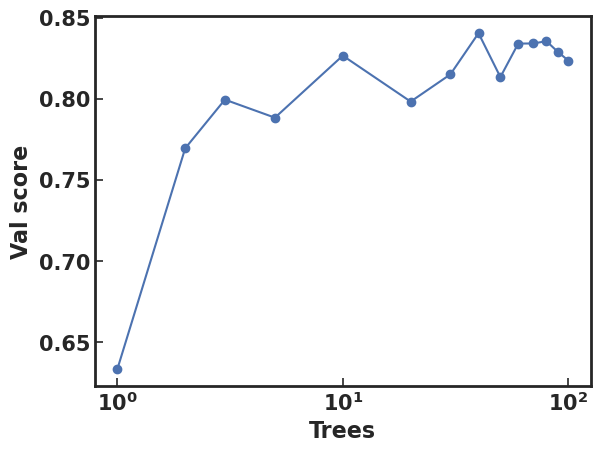

Training set R2:  0.7817285816416589
Test set R2: 0.8002323741863522
Best param 40


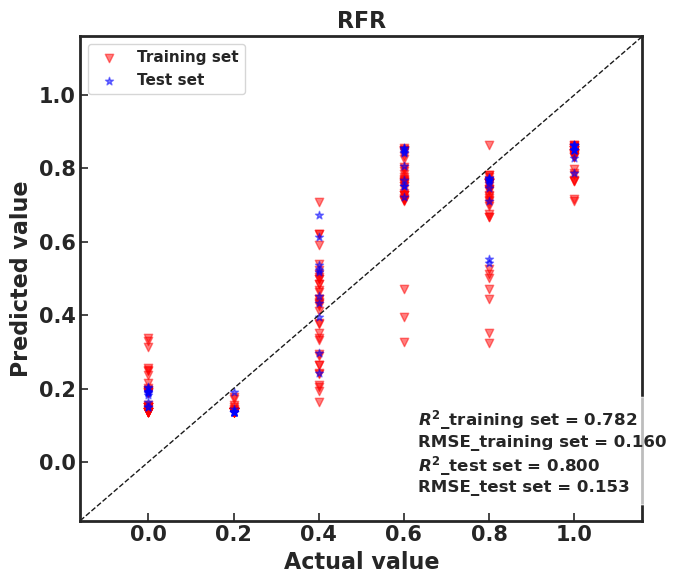

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Each run is random. The result is very unstable

Ns = [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
val_scores = []
for N in Ns:
    rf_regressor = RandomForestRegressor(n_estimators = N, max_depth = 6, min_samples_split = 4, min_samples_leaf = 4).fit(X_train, y_train)
    val_scores.append(rf_regressor.score(X_val, y_val))

# plt.title('val score ~ trees')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Trees',fontsize=16)
plt.ylabel('Val score',fontsize=16)
plt.xscale('log')
plt.plot(Ns, val_scores, marker='o')
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
plt.tick_params(axis='x', which='major', bottom=True, top=False) 
plt.tick_params(axis='y', which='major', left=True, right=False)
# 设置边框加粗
ax = plt.gca()  # 获取当前图形对象
for spine in ax.spines.values():
    spine.set_linewidth(2.0)  # 边框线条加粗
plt.show()

best_hparam = Ns[np.argmax(val_scores)]
rf_regressor = RandomForestRegressor(n_estimators = best_hparam, max_depth = 2)
rf_regressor.fit(X_train, y_train)

y_pred_train = rf_regressor.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = rf_regressor.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))
y_tpred = rf_regressor.predict(X_train)

print('Best param', best_hparam)
draw_regression_plots(y_train, y_tpred, y_test, y_pred, title = 'RFR')

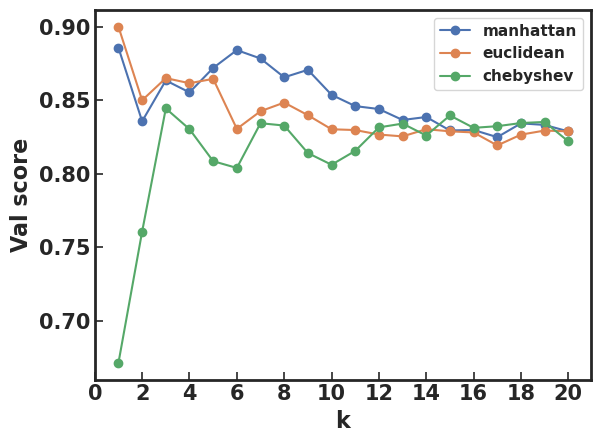

Training set R2: 0.8996031746031746
Test set R2: 0.8957142857142857
Best param 1


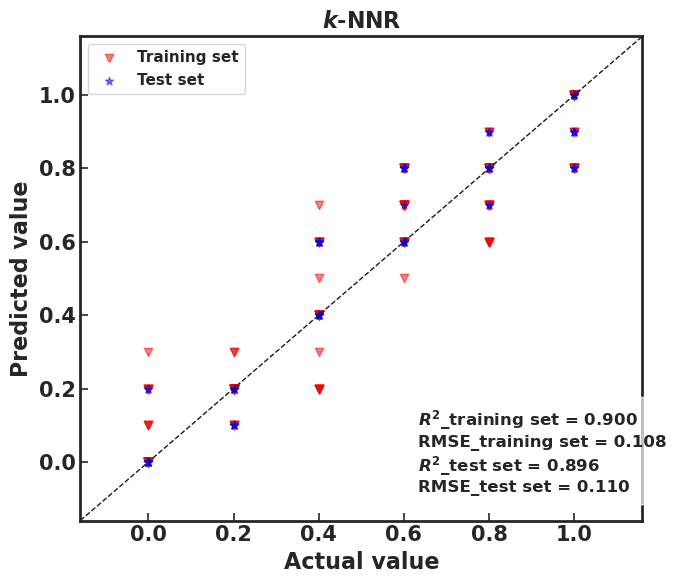

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有 X_train, y_train, X_val, y_val, X_test, y_test 数据

Ns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
metrics = ['manhattan', 'euclidean', 'chebyshev']
best_score = -np.inf
best_hparam = None
best_metric = None

for metric in metrics:
    val_scores = []
    for N in Ns:
        knr = KNeighborsRegressor(n_neighbors=N, metric=metric).fit(X_train, y_train)
        val_score = knr.score(X_val, y_val)
        val_scores.append(val_score)
        
        # 更新最佳参数
        if val_score > best_score:
            best_score = val_score
            best_hparam = N
            best_metric = metric

    # 绘制当前度量下的验证得分曲线，添加数据点
    plt.plot(Ns, val_scores, label=metric, marker='o')

# plt.title('Val score ~ neighbors and metrics')
plt.xlabel('k',fontsize=16)
plt.ylabel('Val score',fontsize=16)
plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.2)  
plt.tick_params(axis='x', which='major', bottom=True, top=False) 
plt.tick_params(axis='y', which='major', left=True, right=False)  
plt.legend()

# 设置 x 轴刻度为间隔为2
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(range(0, 21, 2))
# 设置边框加粗
ax = plt.gca()  # 获取当前图形对象
for spine in ax.spines.values():
    spine.set_linewidth(2.0)  # 边框线条加粗
plt.show()

# 用最佳超参数在训练集和测试集上评估模型
knr = KNeighborsRegressor(n_neighbors=2, metric='euclidean').fit(X_train, y_train)

y_pred_train = knr.predict(X_train)
print('Training set R2:', r2_score(y_train, y_pred_train))

y_pred = knr.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))
y_tpred = knr.predict(X_train)
print('Best param', best_hparam)
# 假设 draw_regression_plots 是一个已经定义的函数
draw_regression_plots(y_train, y_tpred, y_test, y_pred, title=f'$k$-NNR')


144it [00:00, 340.53it/s]


Training set R2:  0.995453229163638
Test set R2: 0.9503793166987351
Best param (5, 0.2)


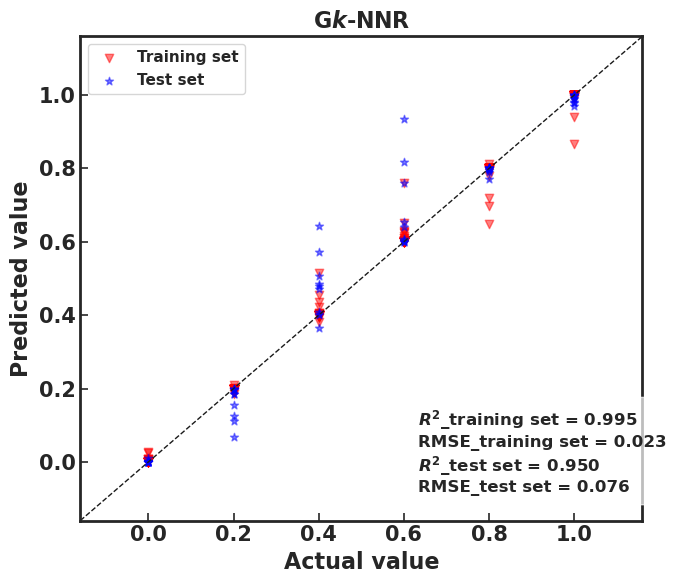

In [63]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
from tqdm import tqdm

class GaussianWeightedKNNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, n_neighbors=80, sigma=1.0, epsilon=0.5):
        self.n_neighbors = n_neighbors
        self.sigma = sigma
        self.epsilon = epsilon
        self.knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.knn.fit(X_train, y_train)
    
    def _gaussian_weights(self, distances):
        distances = np.where(distances == 0, self.epsilon, distances)  # 将距离为0的位置替换为epsilon
        #print("Distances:", distances)
        #distances /= 100  # 将距离除以100
        #print("Distances:", distances)
        weights = np.exp(-distances**2 / (2 * self.sigma**2))
        #print("Weights:", weights)
        return weights
    
    def predict(self, X):

        predictions=[]
        
        for query_point in X:
            #print("X", X)
            distances, indices = self.knn.kneighbors(query_point.reshape(1, -1))
            weights = self._gaussian_weights(distances/np.max(distances))
            normalized_weights = weights / np.sum(weights)
            weighted_sum = np.sum(normalized_weights * self.y_train[indices.flatten()])
            predictions.append(weighted_sum)
            
        return np.array(predictions)

    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
    def gridsearch_hparam(X_train, y_train, X_val = None, y_val = None, ks = [3,4,5,10,15,16,17,18,19,20,21,22,23,24,25,30,35,40], sigmas=[.1,.2,.25,.3,1,10,100,1000]):
        
        best_r2 = -np.inf
        best_clf = None
        best_predictions = None

        hparams = [ks, sigmas]
        
        for k, sigma in tqdm(itertools.product(*hparams)):
            
            clf = GaussianWeightedKNNRegressor(k, sigma)

            if X_val is None or y_val is None:
                X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, shuffle=True, random_state=0)
            clf.fit(X_train, y_train)
            
            score = r2_score(y_val, clf.predict(X_val))            

            # print(k, sigma, score)
            if score > best_r2:
                best_r2 = score
                best_clf = clf
        
        return best_clf

gwknr = GaussianWeightedKNNRegressor.gridsearch_hparam(X_train, y_train, X_val, y_val) 
# print(gwknr.__dir__)
best_hparam = gwknr.n_neighbors, gwknr.sigma

y_pred_train = gwknr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = gwknr.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))
y_tpred = gwknr.predict(X_train)
print('Best param', best_hparam)

draw_regression_plots(y_train, y_tpred, y_test, y_pred, title = 'G$k$-NNR')